# Gaussian Process with Heteroscedastic likelihoods

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra
using Plots
default(lw=3.0, msw=0.0)

using CairoMakie

## Model generated data
The heteroscedastic noise mean that the variance of the likelihood
directly depends on the input.
To model this with Gaussian process, we define a GP `f` for the mean and another GP `g` for the variance
``y \sim f + \epsilon``
where ``\epsilon \sim \mathcal{N}(0, (\lambda \sigma(g))^{-1})``
We create a toy dataset with X ∈ [-10, 10] and sample `f`, `g` and `y` given this same generative model

In [2]:
N = 200
x = (sort(rand(N)) .- 0.5) * 20.0
x_test = range(-10, 10; length=500)
kernel = 5.0 * SqExponentialKernel() ∘ ScaleTransform(1.0) # Kernel function
K = kernelmatrix(kernel, x) + 1e-5I # The kernel matrix
f = rand(MvNormal(K)) # We draw a random sample from the GP prior

200-element Vector{Float64}:
 -4.310190683028496
 -4.309675627928923
 -4.398088840285218
 -4.52695952954026
 -4.637740456508658
 -4.630949215636536
 -4.582750427459629
 -4.442935285601383
 -4.374515248469205
 -4.355667399347488
  ⋮
 -1.7886968245456396
 -1.7343119551310446
 -1.7075275717922367
 -1.6434115786132049
 -1.4530380185882525
 -1.4010492887783164
 -0.7921695191231645
 -0.741326921439437
 -0.725530486316368

We add a prior mean on `g` so that the variance does not become too big

In [3]:
μ₀ = -3.0
g = rand(MvNormal(μ₀ * ones(N), K))
λ = 3.0 # The maximum possible precision
σ = inv.(sqrt.(λ * AGP.logistic.(g))) # We use the following transform to obtain the std. deviation
y = f + σ .* randn(N) # We finally sample the ouput

200-element Vector{Float64}:
  -2.1117079277194377
  -1.8927627118004908
  -6.99934603592172
  -5.522054626284794
  -6.076547014055135
  -0.8600743291320687
   2.1483037020223463
  -4.850689421626725
  -0.8932172013259296
 -14.210773775109132
   ⋮
   8.241009521342985
  -2.2098962828212194
  -1.4310980810620437
   1.4834855674599425
   8.490348916650623
   2.0112674348653043
   5.6201753352258255
   8.94170219830798
 -24.696020420192937

We can visualize the data:

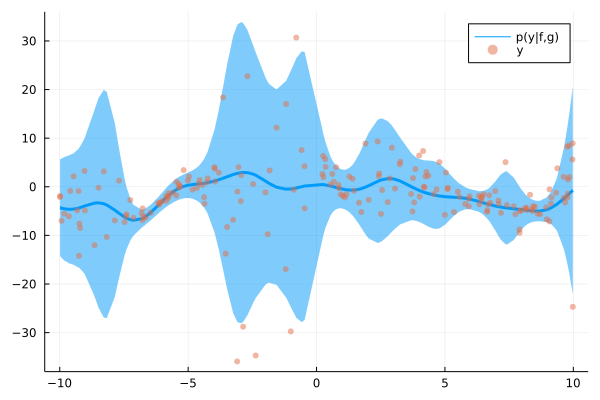

In [4]:
n_sig = 2 # Number of std. dev. around the mean
plot(x, f, ribbon = n_sig * σ, lab= "p(y|f,g)") # Mean and std. dev. of y
scatter!(x, y, alpha=0.5, msw=0.0, lab="y") # Observation samples

## Model creation and training
We will now use the augmented model to infer both `f` and `g`

In [5]:
model = VGP(
    x,
    y,
    deepcopy(kernel),
    HeteroscedasticLikelihood(λ),
    AnalyticVI();
    optimiser=true, # We optimise both the mean parameters and kernel hyperparameters
    mean=μ₀,
    verbose=1,
)

Variational Gaussian Process with a Gaussian likelihood with heteroscedastic noise infered by Analytic Variational Inference 

Model training, we train for around 100 iterations to wait for the convergence of the hyperparameters

In [6]:
train!(model, 100);

[ Info: Starting training Variational Gaussian Process with a Gaussian likelihood with heteroscedastic noise infered by Analytic Variational Inference  with 200 samples, 1 features and 2 latent GPs
[ Info: Training ended after 100 iterations. Total number of iterations 100


## Predictions
We can now look at the predictions and compare them with out original model

In [7]:
(f_m, g_m), (f_σ, g_σ) = predict_f(model, x_test; cov=true)
y_m, y_σ = proba_y(model, x_test)

([-2.1976307248805966, -2.194695325519274, -2.1922653330151802, -2.1904100302073064, -2.1891842479314, -2.188628551622178, -2.1887696535532704, -2.1896210352746706, -2.191183761480555, -2.1934474633222174  …  -1.1931250571747327, -1.1742334397102212, -1.1587555555290194, -1.146742714076744, -1.1382169274467202, -1.1331702770371237, -1.1315645625849626, -1.1333312487957485, -1.138371721331008, -1.146557859761498], [11.103251772075417, 11.602114222256994, 12.174400760523856, 12.823896404970885, 13.554263875241187, 14.36893729579396, 15.270997741334819, 16.263029950432333, 17.346960065176745, 18.523875047281997  …  36.893241076594826, 41.13319915329081, 45.85460164462125, 51.08278456723413, 56.83708404758482, 63.129067331116204, 69.96077490488842, 77.32307599414753, 85.19424772647015, 93.53888711730039])

Let's first look at the differece between the latent `f` and `g`

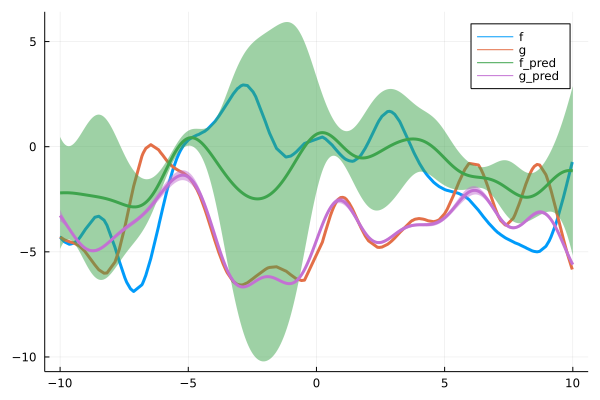

In [8]:
plot(x, [f, g]; label=["f" "g"])
plot!(x_test, [f_m, g_m]; ribbon=[n_sig * f_σ n_sig * g_σ], lab=["f_pred" "g_pred"], legend=true)

But it's more interesting to compare the predictive probability of `y` directly:

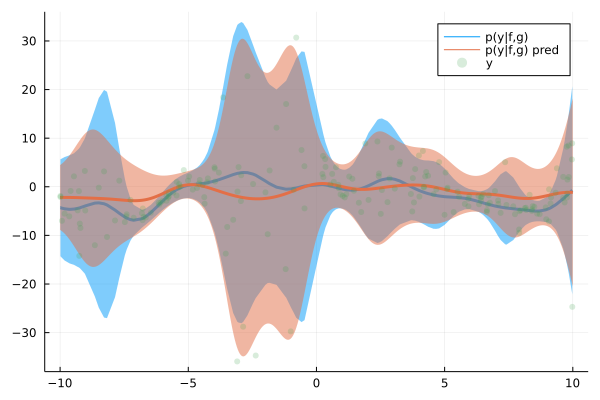

In [9]:
plot(x, f; ribbon = n_sig * σ, lab="p(y|f,g)")
plot!(x_test, y_m, ribbon = n_sig * sqrt.(y_σ), lab="p(y|f,g) pred")
scatter!(x, y; lab="y", alpha=0.2)

Or to explore the heteroscedasticity itself, we can look at the residuals

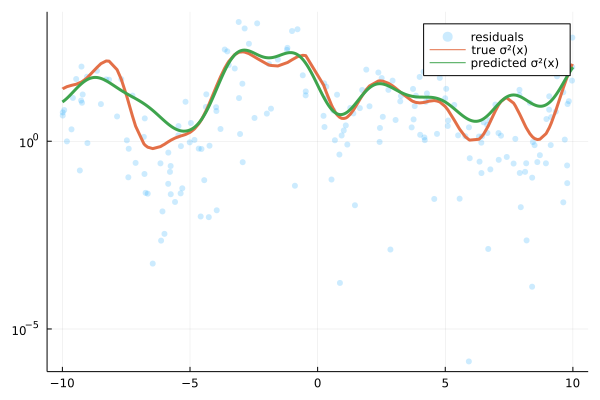

In [10]:
scatter(x, (f - y).^2; yaxis=:log, lab="residuals",alpha=0.2)
plot!(x, σ .^ 2; lab="true σ²(x)")
plot!(x_test, y_σ; lab="predicted σ²(x)")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*